# Практическая работа №2

Грязных В.А (БСМО-11-25)<br> Сароян А.К. (БСМО-11-25)<br> Ершов Н.А. (БСМО-12-25)<br> Дерюгин И.Д. (БСМО-11-25)

## 1. Были собраны друзья и друзья друзей из ВК

In [1]:
import time
import csv
import requests
import os

ACCESS_TOKEN = "" # Здесь был наш токен
API_VERSION = "5.199"
BASE_URL = "https://api.vk.com/method"
PAUSE = 0.35

def vk_get(method, params):
    params["access_token"] = ACCESS_TOKEN
    params["v"] = API_VERSION
    while True:
        time.sleep(PAUSE)
        r = requests.get(f"{BASE_URL}/{method}", params=params, timeout=30).json()
        if "response" in r:
            return r["response"]
        err = r.get("error", {})
        code = err.get("error_code")
        if code in (15, 18, 30):
            return {"items": []}
        if code == 6:
            time.sleep(1.0)
            continue
        raise SystemExit(f"VK error {code}: {err.get('error_msg')}")

def get_friends(uid):
    resp = vk_get("friends.get", {"user_id": uid})
    return resp.get("items", [])

def main():
    team = [538391105, 320989644, 211949287] # Сароян, Дерюгин, Грязных
    output_file = "friends.csv"

    if (ACCESS_TOKEN == "") and (os.path.exists(output_file)):
        print("Нет токена, но уже есть файл") # Если Вы будете запускать код
        return

    all_edges = []

    for idx, user_id in enumerate(team, 1):
        print(f"\nПолучение друзей {user_id}")
        friends = get_friends(user_id)
        all_edges.extend((user_id, fid) for fid in friends)
        print(f"Получено {len(friends)} друзей")

        print(f"Получение друзей друзей {user_id}")
        user_pairs = 0
        for i, fid in enumerate(friends, 1):
            f2 = get_friends(fid)
            all_edges.extend((fid, x) for x in f2)
            user_pairs += len(f2)
        print(f"Получено {user_pairs} пар")

    with open(output_file, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["user_id", "friend_id"])
        w.writerows(all_edges)

    print(f"\nГотово. Сохранено {len(all_edges)} пар в '{output_file}'")

if __name__ == "__main__":
    main()


Получение друзей 538391105
Получено 24 друзей
Получение друзей друзей 538391105
Получено 6053 пар

Получение друзей 320989644
Получено 77 друзей
Получение друзей друзей 320989644
Получено 12405 пар

Получение друзей 211949287
Получено 81 друзей
Получение друзей друзей 211949287
Получено 21028 пар

Готово. Сохранено 39668 пар в 'friends.csv'


## 2. Были удалены дубликаты

In [1]:
import csv

with open("friends.csv", encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)
    pairs = {tuple(sorted((row[0], row[1]))) for row in reader}

pairs = sorted(pairs, key=lambda p: (int(p[0]), int(p[1])))

with open("friends.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["user_id", "friend_id"])
    writer.writerows(pairs)

print(f"Дубликаты удалены, теперь {len(pairs)} уникальных пар.")

Дубликаты удалены, теперь 35967 уникальных пар.


## 3. Для наглядности граф был визуализирован, однако для читаемости были визуально объединены структурно эквивалентные вершины, с добавлением подписи - количества, а также скрыты вершины лишь с 1й связью. (Это было сделано только для визулизации, данные изменены не были)

In [2]:
pip install networkx matplotlib pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 9.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 7.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


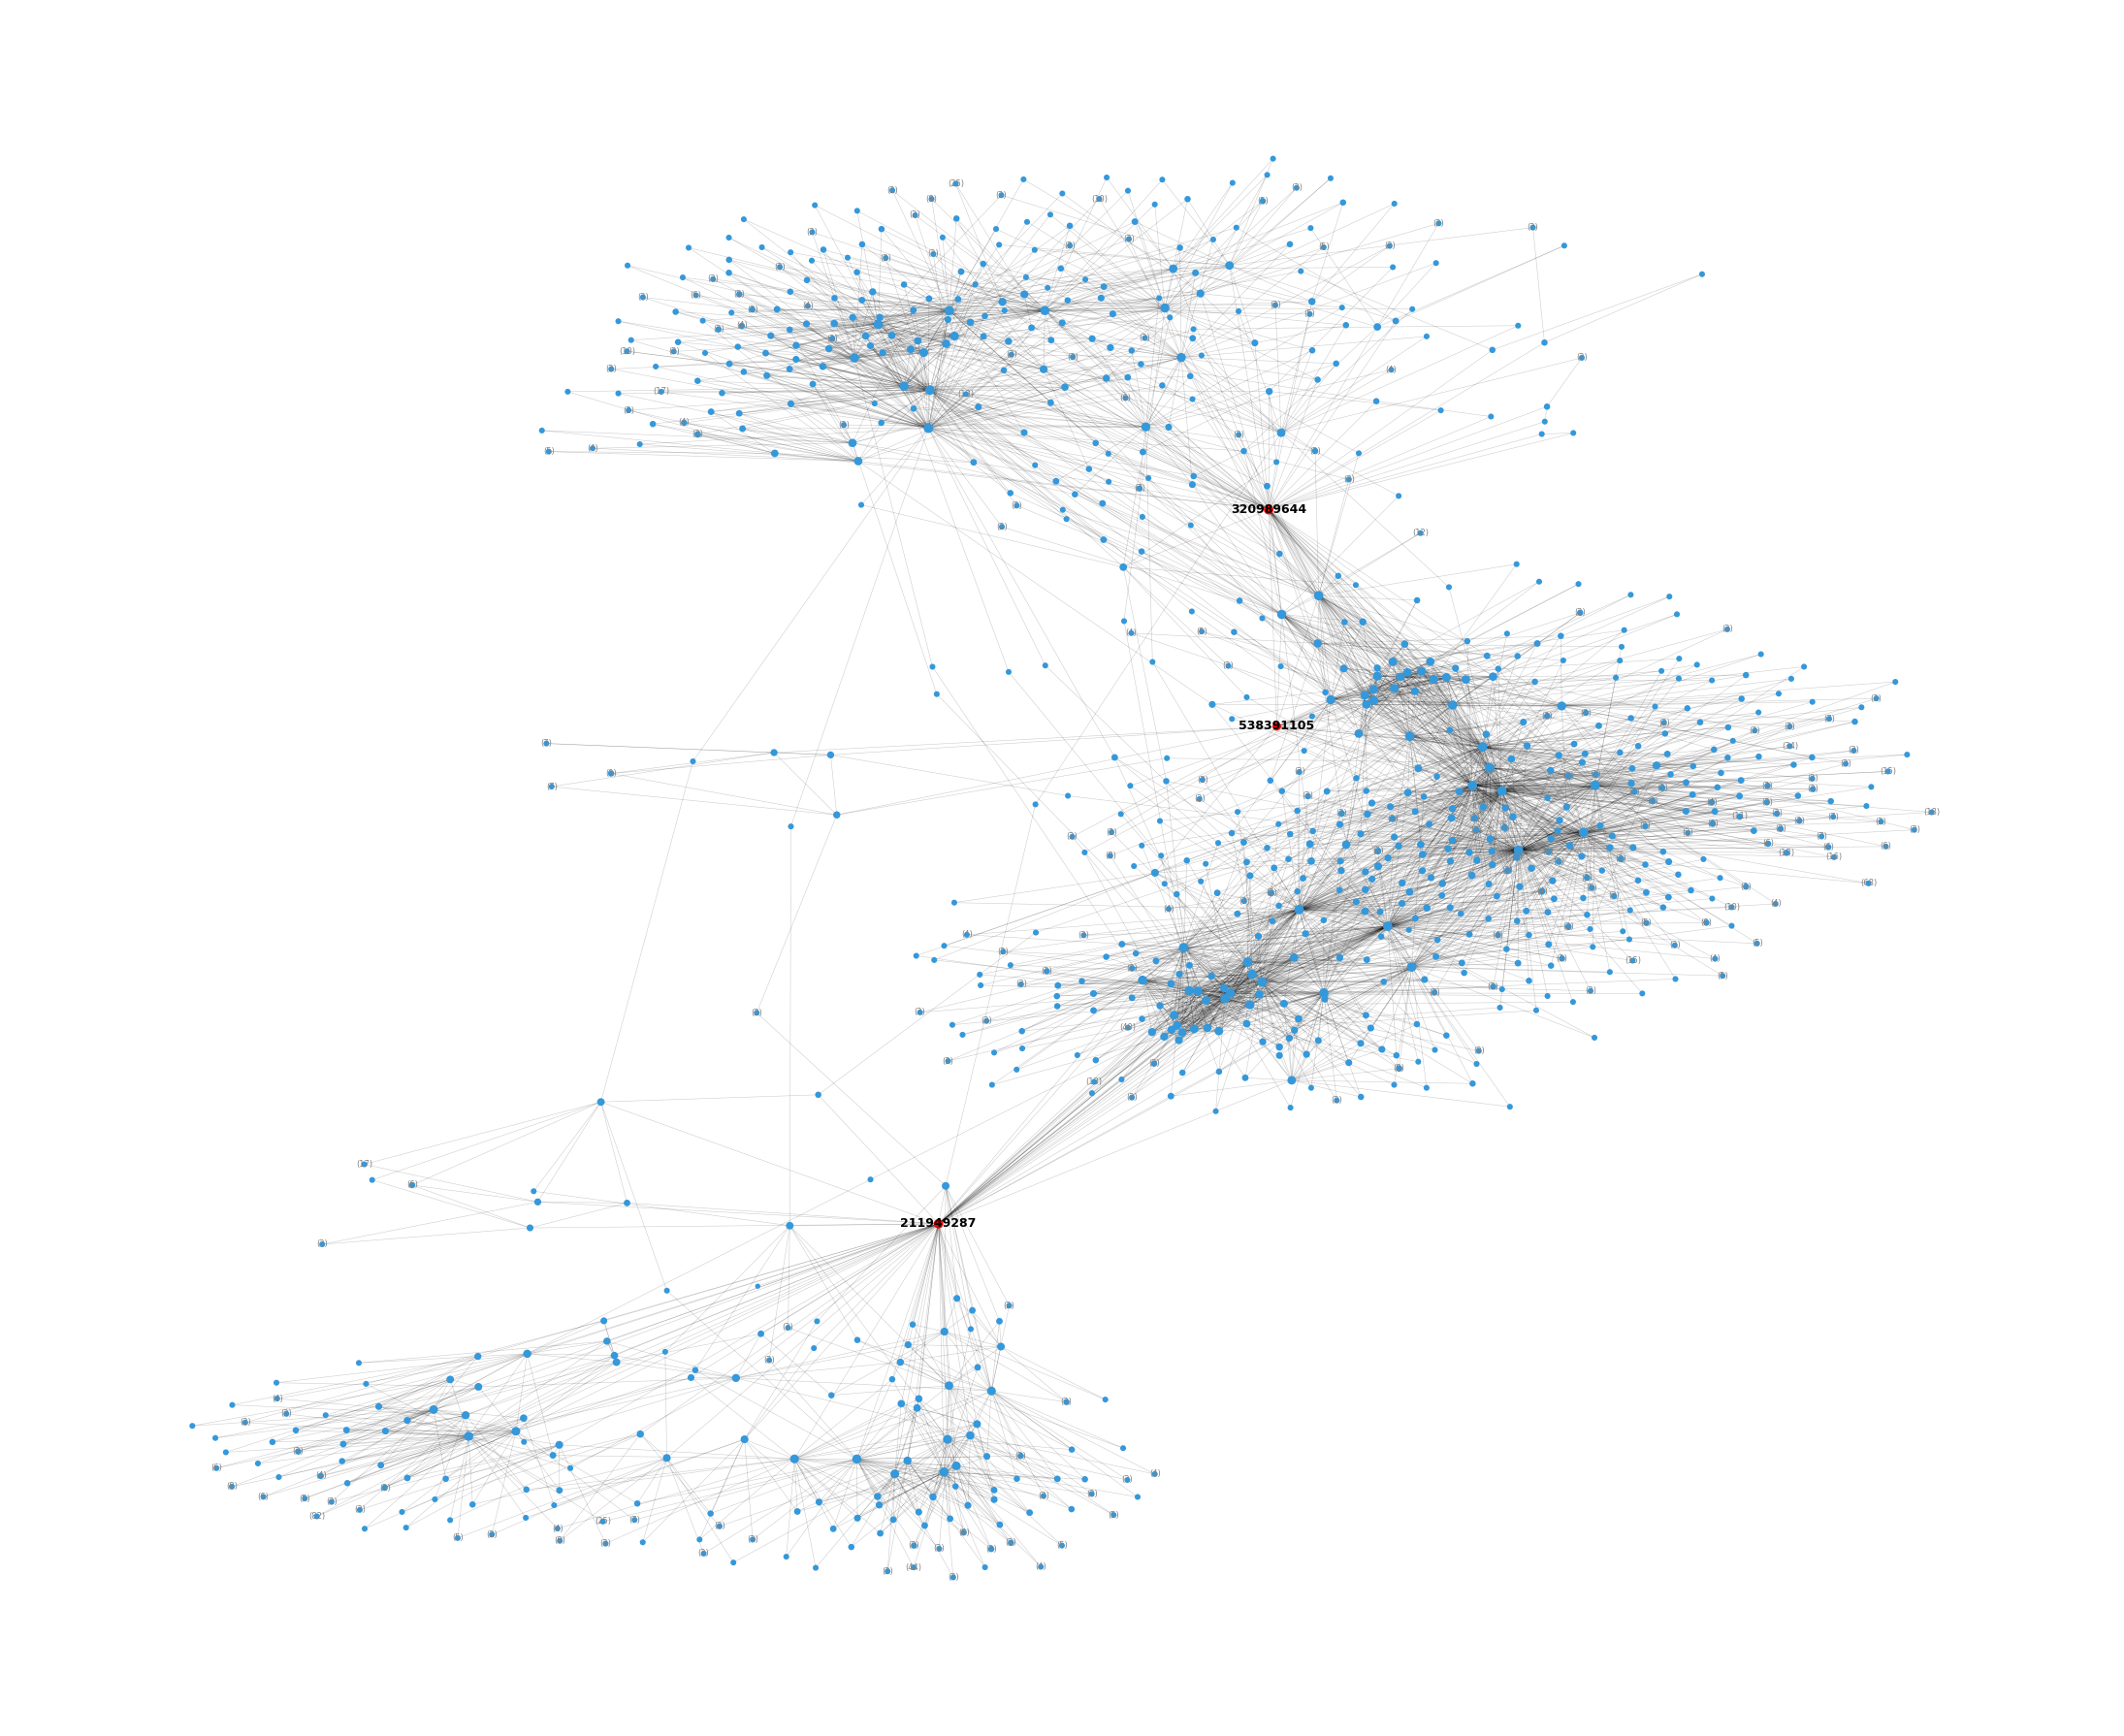

In [3]:
import pandas as pd, math, networkx as nx, matplotlib.pyplot as plt
from collections import defaultdict

FILE = "friends.csv"
OUT_PNG = "friendsGraph.png"
team = [538391105, 320989644, 211949287]

SPACING = 5.0
MIN_SIZE, MAX_SIZE = 10, 50

def load_graph(path):
    df = pd.read_csv(path, dtype=int, usecols=["user_id", "friend_id"])
    G = nx.Graph()
    G.add_edges_from(df.itertuples(index=False, name=None))
    return G

def collapse_structural(G):
    sig2rep, mapping, groups = {}, {}, defaultdict(set)
    for n in G.nodes():
        rep = sig2rep.setdefault(frozenset(G.neighbors(n)), n)
        mapping[n] = rep; groups[rep].add(n)
    H = nx.Graph()
    for u, v in G.edges():
        a, b = mapping[u], mapping[v]
        if a != b: H.add_edge(a, b)
    return H, mapping, groups

def main():
    G0 = load_graph(FILE)
    H, mapping, groups = collapse_structural(G0)

    team_reps = {mapping[t] for t in team if t in mapping}
    H.remove_nodes_from([n for n, d in H.degree() if d <= 1 and n not in team_reps])

    k = SPACING * (1 / math.sqrt(max(1, H.number_of_nodes())))
    pos = nx.spring_layout(H, k=k, iterations=300, seed=42)

    deg = dict(H.degree())
    size = lambda n: max(MIN_SIZE, min(MAX_SIZE, 8 + 10 * math.log1p(deg.get(n, 0))))
    sizes  = [size(n) for n in H.nodes()]
    colors = ["#ff0000" if n in team_reps else "#3498db" for n in H.nodes()]

    plt.figure(figsize=(22, 18))
    nx.draw_networkx_edges(H, pos, width=0.4, alpha=0.2)
    nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color=colors, linewidths=0)

    nodes_in_H = set(H.nodes())
    labels_main = {
        rep: "|".join(map(str, sorted(t for t in team if mapping.get(t) == rep)[:3])) +
             (f"+{len([t for t in team if mapping.get(t)==rep])-3}" if len([t for t in team if mapping.get(t)==rep])>3 else "")
        for rep in (team_reps & nodes_in_H)
    }
    
    labels_small = {rep: f"({len(members)})" for rep, members in groups.items()
                    if rep in nodes_in_H and len(members) > 1}

    nx.draw_networkx_labels(H, pos, labels=labels_main,  font_size=9, font_color="black", font_weight="bold")
    nx.draw_networkx_labels(H, pos, labels=labels_small, font_size=6, font_color="gray")

    plt.axis("off"); plt.tight_layout()
    plt.savefig(OUT_PNG, dpi=320); plt.show()

if __name__ == "__main__":
    main()


## 4. Оцениваем центральность нужных вершин

In [5]:
from collections import deque
import csv
import math
import sys

# =========================
# НАСТРОЙКИ
# =========================
# CSV_PATH — путь к файлу с рёбрами графа. Ожидаются колонки: user_id, friend_id.
# Считаем, что граф НЕориентированный (связь A-B означает связь и A->B, и B->A).
CSV_PATH = "friends.csv"

# team — список вершин (ID), для которых мы хотим увидеть результаты.
team = [538391105, 320989644, 211949287]


# =========================
# ФУНКЦИЯ ЧТЕНИЯ ГРАФА
# =========================
# read_graph читает CSV и строит "списки смежности" — для каждой вершины список её соседей.
# Это удобный формат для обходов графа (например, BFS).
def read_graph(csv_path):
    graph = {}
    with open(csv_path, encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            a = int(row["user_id"])
            b = int(row["friend_id"])
            # setdefault создаёт пустой список, если ключа ещё нет
            graph.setdefault(a, []).append(b)
            graph.setdefault(b, []).append(a)  # двунаправленная связь
    return graph


# =========================
# BFS (ПОИСК В ШИРИНУ) ОТ ОДНОЙ ВЕРШИНЫ
# =========================
# Эта функция делает однотипную работу для нескольких метрик:
# 1) dist[v] — кратчайшая дистанция (в шагах рёбер) от source до v.
# 2) sigma[v] — сколько существует кратчайших путей от source до v.
# 3) preds[v] — список "предшественников" v на кратчайших путях (кто приходит в v по кратчайшему пути).
# 4) order — порядок, в котором мы вытаскивали вершины из очереди (нужен для обратного прохода в Брандесе).
#
# Почему это нужно:
# - Для посредничества нам важно знать, сколько кратчайших путей идут через каждую вершину.
# - Для близости нам нужны сами расстояния.
# - Для eigenvector это не нужно, но BFS мы используем для первых двух метрик.
def bfs_shortest_paths(graph, source):
    # Инициализация: -1 означает "не посещали"
    dist = {v: -1 for v in graph}
    sigma = {v: 0 for v in graph}
    preds = {v: [] for v in graph}

    dist[source] = 0     # до себя расстояние 0
    sigma[source] = 1    # до себя есть ровно 1 "путь" (тривиальный)

    q = deque([source])  # очередь для обхода в ширину
    order = []           # сюда запишем фактический порядок, в котором извлекали вершины из очереди

    while q:
        v = q.popleft()      # достаём первый элемент быстро (в этом плюс deque)
        order.append(v)
        for w in graph.get(v, []):
            # Первый раз видим вершину — задаём ей расстояние и ставим в очередь
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                q.append(w)
            # Если нашли путь в w с длиной ровно на 1 больше, чем до v — значит это один из кратчайших путей
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]   # наращиваем число кратчайших путей до w
                preds[w].append(v)     # v — предшественник w по кратчайшему пути

    return dist, sigma, preds, order


# =========================
# 1) ПОСРЕДНИЧЕСТВО (BETWEENNESS), НОРМАЛИЗОВАННОЕ
# =========================
# Интуитивно: вершина высокая по посредничеству, если через неё проходит много
# кратчайших путей между другими парами вершин.
#
# Как считаем:
# - Для КАЖДОЙ вершины s запускаем BFS (получаем dist, sigma, preds, order).
# - Дальше идём в обратном порядке (stack-ом) и "распределяем вклад" dependency от потомков к предкам.
# - Накопленный вклад складываем в C.
#
# В конце:
# - Делим на 2 (для НЕориентированного графа, потому что пары (s,t) и (t,s) считаются вместе).
# - Нормализуем на максимум (n-1)(n-2)/2, чтобы значения были ~в диапазоне [0;1].
def betweenness_centrality(graph):
    nodes = list(graph.keys())
    n = len(nodes)
    C = {v: 0.0 for v in nodes}  # сюда копим "посредничество" по определению

    for i, s in enumerate(nodes, start=1):
        # Простой прогресс-бар: 50 символов шириной
        bar = int((i / n) * 50)
        sys.stdout.write(f"\rПосредничество: {i}/{n} [{'#'*bar}{'.'*(50-bar)}]")
        sys.stdout.flush()

        dist, sigma, preds, order = bfs_shortest_paths(graph, s)

        # dependency (вклад): сколько "веса путей" должна получить каждая вершина как предок
        delta = {v: 0.0 for v in nodes}
        # Разбираем в обратном порядке обхода — сначала дальние, затем ближе к source
        while order:
            w = order.pop()
            for v in preds[w]:
                if sigma[w] > 0:
                    # доля путей в w, пришедших из v, умноженная на (1 + уже накопленный вклад у w)
                    delta[v] += (sigma[v] / sigma[w]) * (1.0 + delta[w])
            if w != s:
                C[w] += delta[w]

    # Для неориентированного графа каждая пара учитывалась дважды — делим пополам
    for v in C:
        C[v] /= 2.0

    # Нормализация: делим на теоретический максимум для неориентированного графа
    # Максимум = (n - 1)(n - 2) / 2
    if n > 2:
        norm = (n - 1) * (n - 2) / 2.0
        for v in C:
            C[v] /= norm

    print()  # перенос строки после прогресс-бара
    return C


# =========================
# 2) БЛИЗОСТЬ (CLOSENESS)
# =========================
# Интуитивно: вершина высокая по близости, если в среднем она "близко" (по кратчайшим расстояниям) ко всем другим.
# Простая формула: C_clo(i) = (n-1) / sum_j d(i,j), где d(i,j) — кратчайшее расстояние от i до j.
# Если какая-то часть графа недостижима из i, в сумме остаются только достижимые расстояния (остальные игнорируем).
#
# Мы считаем близость только для вершин из team (так быстрее, если team небольшой).
def closeness_centrality_for_team(graph, team_nodes):
    nodes = list(graph.keys())
    n = len(nodes)
    C = {}

    total = len(team_nodes)
    for i, s in enumerate(team_nodes, start=1):
        bar = int((i / total) * 50)
        sys.stdout.write(f"\rБлизость (для team): {i}/{total} [{'#'*bar}{'.'*(50-bar)}]")
        sys.stdout.flush()

        if s not in graph:
            C[s] = 0.0
            continue

        dist, _, _, _ = bfs_shortest_paths(graph, s)
        # Суммируем только положительные расстояния (0 до себя не считаем)
        total_dist = sum(d for u, d in dist.items() if u != s and d > 0)
        if total_dist > 0:
            C[s] = (n - 1) / total_dist
        else:
            # Если вершина изолирована (никого не достигает), близость нулевая.
            C[s] = 0.0

    print()
    return C


# =========================
# 3) СОБСТВЕННЫЙ ВЕКТОР (EIGENVECTOR CENTRALITY)
# =========================
# Идея: вершина "важна", если она связана с "важными" вершинами.
# Это решается как задача на собственный вектор: A x = λ x, где A — матрица смежности.
# Мы считаем x численным методом — "степенным методом":
#   - берём начальный вектор x (все единицы),
#   - многократно умножаем его на A (это просто суммирование по соседям),
#   - каждый раз нормируем (чтобы числа не убегали),
#   - останавливаемся, когда значения перестают меняться (diff < tol) или прошли max_iter итераций.
def eigenvector_centrality(graph, max_iter=100, tol=1e-6):
    nodes = list(graph.keys())
    x = {v: 1.0 for v in nodes}  # старт: у всех по 1

    for it in range(max_iter):
        # Прогресс-бегунок по итерациям
        bar = int((it / max_iter) * 50)
        sys.stdout.write(f"\rСобств. вектор: итерация {it+1}/{max_iter} [{'#'*bar}{'.'*(50-bar)}]")
        sys.stdout.flush()

        # y = A x: значение вершины — сумма значений её соседей
        y = {v: 0.0 for v in nodes}
        for v in nodes:
            y[v] = sum(x[u] for u in graph.get(v, []))

        # Нормируем по L2-норме (квадратный корень из суммы квадратов)
        norm = math.sqrt(sum(val*val for val in y.values()))
        if norm == 0.0:
            # граф без рёбер — все центральности 0
            break
        for v in nodes:
            y[v] /= norm

        # Проверяем, насколько изменился вектор
        diff = max(abs(y[v] - x[v]) for v in nodes)
        x = y
        if diff < tol:
            # Достигли "почти неизменности" — останавливаемся
            break

    print()
    return x


# =========================
# ОСНОВНОЙ БЛОК ЗАПУСКА
# =========================
if __name__ == "__main__":
    # 1) Загружаем граф
    graph = read_graph(CSV_PATH)

    # 2) Считаем все нужные метрики
    #    ВАЖНО: посредничество считаем по всему графу (таково определение),
    #    потом просто выводим значения только для team.
    betweenness = betweenness_centrality(graph)                             # нормализованное
    closeness   = closeness_centrality_for_team(graph, [v for v in team if v in graph])
    eigenvector = eigenvector_centrality(graph, max_iter=150, tol=1e-8)

    # 3) Делаем "срезы" только по нужным вершинам (чтобы удобно печатать и дальше использовать)
    betweenness_team = {v: betweenness.get(v, 0.0) for v in team}
    closeness_team   = {v: closeness.get(v, 0.0) for v in team}
    eigenvector_team = {v: eigenvector.get(v, 0.0) for v in team}

    # 4) Печатаем результаты максимально просто и по групам метрик (как просили)
    print("\nПОСРЕДНИЧЕСТВО (Нормализованое):")
    for v, val in betweenness_team.items():
        print(f"{v}: {val:.6f}")

    print("\nБЛИЗОСТЬ:")
    for v, val in closeness_team.items():
        print(f"{v}: {val:.6f}")

    print("\nСОБСТВЕННЫЙ ВЕКТОР:")
    for v, val in eigenvector_team.items():
        print(f"{v}: {val:.6f}")


Посредничество: 32054/32054 [##################################################]
Близость (для team): 3/3 [##################################################]
Собств. вектор: итерация 150/150 [#################################################.]

ПОСРЕДНИЧЕСТВО (Нормализованое):
538391105: 0.057535
320989644: 0.158216
211949287: 0.559166

БЛИЗОСТЬ:
538391105: 0.264394
320989644: 0.282961
211949287: 0.349927

СОБСТВЕННЫЙ ВЕКТОР:
538391105: 0.000054
320989644: 0.000053
211949287: 0.032201
